In [35]:
import re
import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from google.colab import drive
from skimage.io import imread
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as ks 

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import cv2
arr=[]
labels = []
num_nonfaces =[]
image1 =[]
accff=[]
i=0
nonfaces=0
for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset2"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg"): 
        nonfaces = nonfaces + 1 
        #image1 = io.imread(os.path.join(root,name))
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))  
      res=re.findall('(\d+)',root_folder[1]) ##
      #image1 = image.imread(os.path.join(root,name))
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      #print(image1)
      arr.append(image1)
      labels.append(int(res[0]))
      i=i+1
num_nonfaces.append( nonfaces)     
arr=np.array(arr)   
labels=np.array(labels)    
print(labels.shape)       
print(arr.shape)
#print(labels)      

(600,)
(600, 10304)


In [38]:
print(labels.shape)       
print(arr.shape)
#print(labels)

(600,)
(600, 10304)


In [39]:
# adding the data to a dataframe
df = pd.DataFrame(arr) 
df['label'] = pd.DataFrame(labels)
# sorting the data according to labels
df.sort_values("label", inplace=True)
df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,label
332,58,54,57,57,54,54,53,61,55,56,...,97,82,66,85,92,99,97,115,128,2
331,103,102,104,104,105,101,104,102,103,104,...,150,155,151,174,166,160,139,152,178,2
330,122,121,121,123,124,123,121,125,124,125,...,73,78,75,78,75,81,78,78,80,2
329,108,105,105,108,106,107,105,108,105,106,...,139,147,169,156,142,139,169,147,165,2
328,56,58,50,51,51,55,54,54,56,57,...,88,90,126,148,172,153,63,75,189,2
327,107,103,104,102,105,103,105,103,106,102,...,143,152,151,152,175,167,155,133,159,2
326,109,110,113,111,112,110,111,112,110,112,...,56,50,50,54,52,55,49,52,51,2
325,58,55,52,54,55,53,55,57,48,58,...,54,54,101,93,112,142,131,115,68,2
335,49,65,53,56,51,61,54,55,59,53,...,67,55,92,101,94,121,134,130,145,2
599,155,154,153,157,154,156,153,153,155,153,...,137,141,135,123,112,111,113,110,111,2


In [40]:
# seperating images from labels
Y = np.array(df['label'])
df = df.drop(axis=1, labels="label")

In [41]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  

for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])

[157 156 153 ... 141 141 133]
1


In [42]:
def PCA(X):
  # X           ---> data to be reduced
  # alpha       ---> total variance threshold
  # evectors    ---> eigen vectors used to reduce the dimensionality

  # calculate the mean
  mean = np.mean(X,axis=0)
  # center the data
  z = X - mean
  # calculate covariance matrix
  cov = (1/X.shape[0])*np.dot(z.T,z)
  # calculate eigenvalues and eigenvectors
  (evalues, evectors) = np.linalg.eigh(cov)
  evalues = np.flip(evalues)
  evectors = np.flip(evectors,axis=1)
  return (evalues, evectors)
     


In [43]:
def choose_dim(evalues, evectors, alpha):
  # fraction of total variance
  fr = evalues/evalues.sum()

  totvar = 0
  i = 0

  while(totvar < alpha):
    totvar = totvar + fr[i]
    i = i + 1

  # choose dimensionality
  evectors = evectors[ : , 0:i]

  return evectors
     

In [44]:
def reduce_dim(X, evectors):
  reducedmat = np.matmul(evectors.T,X.T).T
  return reducedmat
     

In [45]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
(evalues, evectors) = PCA(arr)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
     

In [ ]:
# saving the PCA output for later use
file_name = 'PCA_output.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(evalues, file)
    print(f'PCA eigen values successfully saved to "{file_name}"')
    pickle.dump(evectors, file)
    print(f'PCA eigen vectors successfully saved to "{file_name}"')

In [ ]:
file_name = 'PCA_output.pkl'
with open(file_name, 'rb') as file:
    evalues  = pickle.load(file)
    print(f'PCA eigen values successfully loaded from "{file_name}"')
    evectors  = pickle.load(file)
    print(f'PCA eigen vectors loaded from "{file_name}"')

In [ ]:

# after reducing with PCA with r = 0.8
print("After PCA with r = 0.8")
evectors_red = choose_dim(evalues, evectors, 0.8)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.85
print("After PCA with r = 0.85")
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.9
print("After PCA with r = 0.9")
evectors_red = choose_dim(evalues, evectors, 0.9)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.95
print("After PCA with r = 0.95")
evectors_red = choose_dim(evalues, evectors, 0.95)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

In [ ]:
accuracies=[]
num_k=[]
alphas=[]
def Accuracies(num,alpha,X_train,X_test,labels_train, labels_test):
    num_k.append(num)
    alphas.append(alpha)
    print("After PCA with r = ",alpha,"k = ",num)
    yhat = KNN(X_train, X_test, labels_train, num)
    accuracies.append(accuracy_score(labels_test, yhat))
    test_score = accuracy_score(labels_test, yhat) * 100
    print(f"Testing Set Accuracy: {test_score}")

In [ ]:
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
Accuracies(1,0.85,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(3,0.85,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(5,0.85,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(7,0.85,X_train_red,X_test_red,labels_train,labels_test)

evectors_red = choose_dim(evalues, evectors, 0.9)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
Accuracies(1,0.9,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(3,0.9,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(5,0.9,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(7,0.9,X_train_red,X_test_red,labels_train,labels_test)

evectors_red = choose_dim(evalues, evectors, 0.95)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
Accuracies(1,0.95,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(3,0.95,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(5,0.95,X_train_red,X_test_red,labels_train,labels_test)
Accuracies(7,0.95,X_train_red,X_test_red,labels_train,labels_test)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(num_k, alphas, accuracies)
plt.xlabel('KNN Classifier')
plt.ylabel('alpha')
plt.show()

In [34]:
accPCA=[]
numberofnonfaces=[]

In [46]:
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accPCA.append(accuracy_score(labels_test, yhat))
numberofnonfaces.append(nonfaces)
print(accPCA)
print(numberofnonfaces)

In [48]:
print(accPCA)
print(numberofnonfaces)

[0.9966666666666667]
[200]


In [60]:
 # after changing
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  

for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
(evalues, evectors) = PCA(arr)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accPCA.append(accuracy_score(labels_test, yhat))
numberofnonfaces.append(nonfaces)
#test_score = accuracy_score(labels_test, yhat) * 100
#print(f"Testing Set Accuracy: {test_score}")
#Accuracies(1,0.85,X_train_red,X_test_red,labels_train,labels_test)     

In [67]:
print(accPCA)
print(numberofnonfaces)

[0.99666667 0.99733333 0.99763033 0.99788136 0.99885845]
[ 200  350  444  544 1352]


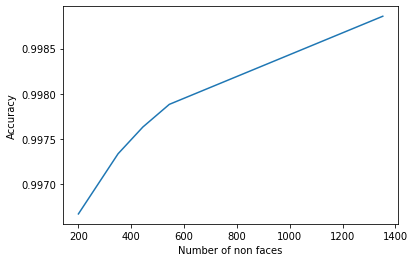

In [68]:
plt.plot(numberofnonfaces , accPCA)
plt.xlabel('Number of non faces')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def KNN(X_train, X_test, y_train, k):   
  # predicted label
  yPredicted = []
  for i in range(len(X_test)):
    # measuring the distance between that test point each train point
    dist = dict([(j, np.sqrt(np.sum((X_test[i] - X_train[j])**2))) for j in range(len(X_train))])
    # sorting the distances
    dist = sorted(dist.items(), key=lambda kv:(kv[1], kv[0]))
    # considering only the k closest points
    dist = dict(dist[:k])
    # print(dist)
    # creating a counter object to track the labels of k closest neighbors
    counter = Counter([y_train[k] for k in dist.keys()])
    # getting the most common label of all the nearest neighbors
    yPredicted.append(counter.most_common()[0][0])
    # print(counter.most_common()[0][0])
  return yPredicted

In [ ]:
def projectData(X_train, X_test, W):
    X_train = np.array([np.matmul(W.T, X_train[i]) for i in range(X_train.shape[0])])
    X_test = np.array([np.matmul(W.T, X_test[i]) for i in range(X_test.shape[0])])
    return X_train, X_test

In [49]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/11"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    
#AfterChanging_nonfaces()

(750,)
(750, 10304)


In [52]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/21"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(844,)
(844, 10304)


In [62]:
print(labels.shape)       
print(arr.shape)

(1752,)
(1752, 10304)


In [56]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/2"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(944,)
(944, 10304)


In [ ]:
#Call the cell of
#AfterChanging_nonfaces()

In [59]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/1"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(1752,)
(1752, 10304)


In [ ]:
#Call the cell of
#AfterChanging_nonfaces()
print(num_nonfaces)

[200, 350, 444, 544, 1352]


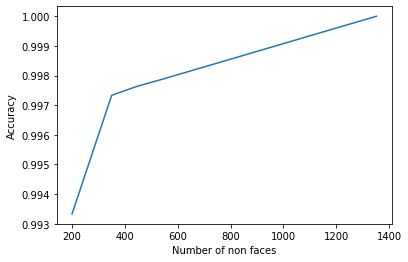

In [ ]:
plt.plot(num_nonfaces , accff)
plt.xlabel('Number of non faces')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
####################################################################################################################

In [ ]:
#### 7.iii
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
acc=[]
s=[]
f=[]
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, labels_train)
#before reduction
#pred = knn.predict(X_test)
#print('labels test',labels_test)
#print(pred)
knn.score(X_test, labels_test)


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_red, labels_train)
print(knn.score(X_test_red, labels_test))
pred = knn.predict(X_test_red)
print(accuracy_score(pred,labels_test))
acc.append(accuracy_score(pred,labels_test))

pred = knn.predict(X_test_red)
#print(X_test_red,labels_test)
#print('labels test',labels_test)
#print(pred)
for i in range(len(pred)):
    if(labels_test[i] != pred[i]):
       f.append([X_test_red[i],labels_test[i]])
    else:
       s.append([X_test_red[i],labels_test[i]])
print(f[0])       

0.7867298578199052
0.7867298578199052
[array([ 8.95092952, 61.22145525]), 1]


In [ ]:
def KMC(X, k, epsilon=0.01, maxIter=100):
  # initializing the error to be max at first
  err = float('inf')
  # randomly initializing the centroids
  centroid = [X[np.random.randint(0, len(X)-1)] for i in range(k)]
  while maxIter > 0 and err >= epsilon:
    maxIter -= 1
    cluster = [[] for i in range(k)]
    # copying the old centroids
    oldCentroid = copy.deepcopy(centroid)
    # assigning each data point to closest cluster
    for x in X:
      minn, j = float('inf'), 0
      for i in range(len(centroid)):
        dist = np.linalg.norm(x-centroid[i]) ** 2
        if dist < minn: minn, j = dist, i
      cluster[j].append(x)
    # updating the centroids
    for i in range(len(cluster)):
      if len(cluster[i]) != 0: centroid[i] = sum(cluster[i]) / len(cluster[i])
    # if centroids didn't change, then terminate
    err = 0
    for i in range(len(centroid)):
      err += np.linalg.norm(centroid[i] - oldCentroid[i]) ** 2
  return cluster